In [1]:
import numpy as np
import pandas as pd

In [207]:
total_data = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/finecops_ref/final_finecopes_ref_30k_bb_annot.csv")

In [208]:
total_data

,image_id,question,caption,target_words
0,2414839,Where is the woman located in relation to the ...,"Situated to the left of the building, which is...","[{'word': 'building', 'h': 343, 'w': 80, 'y': ..."
1,2350091,What color is the cow located to the right of ...,The cow of the same color as the spots to the ...,"[{'word': 'brown cow', 'h': 193, 'w': 301, 'y'..."
2,2334503,"What is standing by the fountain, and where is...",The duck that is standing by the fountain that...,"[{'word': 'duck', 'h': 105, 'w': 126, 'y': 79,..."
3,2408590,Where is the car located in relation to the wo...,The car that is to the right of the woman that...,"[{'word': 'car', 'h': 269, 'w': 376, 'y': 54, ..."
4,2383641,Where is the green plant located relative to t...,"By the white television and resting on it, the...","[{'word': 'cord', 'h': 177, 'w': 71, 'y': 11, ..."
...,...,...,...,...
29826,2399961,What is the giraffe in front of?,The brown and tall fence that is behind the gi...,"[{'word': 'fence', 'h': 277, 'w': 468, 'y': 97..."
29827,2412522,What is the woman located in front of in the s...,The woman that is in front of the blue ship th...,"[{'word': 'boat', 'h': 85, 'w': 290, 'y': 213,..."
29828,2339206,What is the bare log resting beside in the image?,The seedling located close to the bare log tha...,"[{'word': 'log', 'h': 55, 'w': 284, 'y': 320, ..."
29829,2386627,What kind of teddy bear is the white truck par...,The white truck parked on the street to the ri...,"[{'word': 'street', 'h': 68, 'w': 89, 'y': 174..."


In [209]:
total_data["image_id"] = total_data["image_id"].apply(lambda x: str(int(x)))

In [210]:
total_data.head(2)

,image_id,question,caption,target_words
0,2414839,Where is the woman located in relation to the ...,"Situated to the left of the building, which is...","[{'word': 'building', 'h': 343, 'w': 80, 'y': ..."
1,2350091,What color is the cow located to the right of ...,The cow of the same color as the spots to the ...,"[{'word': 'brown cow', 'h': 193, 'w': 301, 'y'..."


In [ ]:
def reformat_bounding_boxes(data):
    reformat_bb_info = []
    for i in eval(data):
        reformat_bb_info.append({'word': i['word'], 'bbox': [{'x': i['x'], 'y': i['y'], 'h': i['h'], 'w': i['w']}]})
    return reformat_bb_info


In [212]:
total_data["target_words"] = total_data["target_words"].apply(lambda x: reformat_bounding_boxes(x))

In [213]:
total_data["target_words"].iloc[0]

[{'word': 'building', 'bbox': [{'x': 57, 'y': 7, 'h': 343, 'w': 80}]},
 {'word': 'man', 'bbox': [{'x': 220, 'y': 246, 'h': 91, 'w': 44}]},
 {'word': 'woman', 'bbox': [{'x': 0, 'y': 258, 'h': 208, 'w': 88}]},
 {'word': 'walking', 'bbox': [{'x': 220, 'y': 246, 'h': 91, 'w': 44}]},
 {'word': 'left of', 'bbox': [{'x': 57, 'y': 7, 'h': 343, 'w': 80}]},
 {'word': 'left of', 'bbox': [{'x': 57, 'y': 7, 'h': 343, 'w': 80}]},
 {'word': 'easily', 'bbox': [{'x': 381, 'y': 242, 'h': 86, 'w': 106}]}]

In [214]:
def convert_bboxes_hwxy_to_xyxy(data, image_width, image_height, clip=True):

    def clamp(v, low, high):
        return max(low, min(high, v))

    out = []

    for item in data:
        new_item = {
            "word": item.get("word"),
            "class": item.get("class"),
            "bbox": []
        }

        for box in item.get("bbox", []):
            x = int(box.get("x", 0))
            y = int(box.get("y", 0))
            w = int(box.get("w", 0))
            h = int(box.get("h", 0))

            xmin = x
            ymin = y
            xmax = x + w
            ymax = y + h

            if clip:
                xmin = clamp(xmin, 0, image_width)
                xmax = clamp(xmax, 0, image_width)
                ymin = clamp(ymin, 0, image_height)
                ymax = clamp(ymax, 0, image_height)

            new_item["bbox"].append(
                {
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax,
                }
            )

        out.append(new_item)

    return out

In [215]:
from PIL import Image
from tqdm import tqdm

new_bboxes_list = []
for idx, row in tqdm(total_data.iterrows()):
    image_path = "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + row["image_id"] + ".jpg"
    img_shape = Image.open(image_path).size
    image_width = img_shape[0]
    image_height = img_shape[1]
    target_words = row['target_words']
    converted_bboxes = convert_bboxes_hwxy_to_xyxy(target_words, image_width, image_height, clip=True)
    new_bboxes_list.append(converted_bboxes)
    # break

29831it [00:06, 4411.54it/s]


In [216]:
total_data["target_words"] = new_bboxes_list

In [217]:
total_data["target_words"].iloc[0]

[{'word': 'building',
  'class': None,
  'bbox': [{'xmin': 57, 'ymin': 7, 'xmax': 137, 'ymax': 350}]},
 {'word': 'man',
  'class': None,
  'bbox': [{'xmin': 220, 'ymin': 246, 'xmax': 264, 'ymax': 337}]},
 {'word': 'woman',
  'class': None,
  'bbox': [{'xmin': 0, 'ymin': 258, 'xmax': 88, 'ymax': 466}]},
 {'word': 'walking',
  'class': None,
  'bbox': [{'xmin': 220, 'ymin': 246, 'xmax': 264, 'ymax': 337}]},
 {'word': 'left of',
  'class': None,
  'bbox': [{'xmin': 57, 'ymin': 7, 'xmax': 137, 'ymax': 350}]},
 {'word': 'left of',
  'class': None,
  'bbox': [{'xmin': 57, 'ymin': 7, 'xmax': 137, 'ymax': 350}]},
 {'word': 'easily',
  'class': None,
  'bbox': [{'xmin': 357, 'ymin': 242, 'xmax': 357, 'ymax': 328}]}]

In [191]:
# bounding box scaling

In [218]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def plot_bounding_boxes_xyxy(image_path, boxes):
    """
    Plots bounding boxes on an image using matplotlib.

    Args:
        image_path (str): Path to the image file.
        boxes (list[dict]): List of bounding boxes in dict format.
                            Each box should have keys: {'xmin', 'ymin', 'xmax', 'ymax'}
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Get a set of distinct colors
    colors = list(plt.cm.tab10.colors)
    random.shuffle(colors)

    # Draw each bounding box
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        color = colors[i % len(colors)]
        
        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        
        # Label each box
        ax.text(xmin, ymin - 5, f"Box {i+1}", color=color,
                fontsize=10, fontweight="bold", backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [219]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def _to_pil(img, image_processor=None):
    """Convert PIL / numpy / processor-normalized tensor -> PIL.Image (uint8)."""
    if isinstance(img, Image.Image):
        return img

    if isinstance(img, torch.Tensor):
        # Accept (B,3,H,W) or (3,H,W). If normalized, unnormalize via processor.
        if img.ndim == 4:
            img = img[0]
        assert img.ndim == 3 and img.shape[0] in (1,3), "Expect (C,H,W) tensor."
        x = img.clone()

        # If in [-~3, ~3] range (typical normalized), try unnormalize
        if image_processor is not None and (x.max() > 1.5 or x.min() < -0.5):
            mean = torch.tensor(
                getattr(image_processor, "image_mean", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            std = torch.tensor(
                getattr(image_processor, "image_std", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            x = x * std + mean

        # Move to CPU, [0,1], CHW->HWC uint8
        x = x.clamp(0,1).permute(1,2,0).detach().cpu().numpy()
        arr = (x * 255).round().astype(np.uint8)
        return Image.fromarray(arr)

    if isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            arr = np.clip(img, 0, 1)
            arr = (arr * 255).round().astype(np.uint8)
        else:
            arr = img
        if arr.ndim == 3 and arr.shape[2] == 3:
            return Image.fromarray(arr)
        raise ValueError("NumPy image must be HxWx3.")
    raise TypeError("Unsupported image type. Use PIL.Image, torch.Tensor, or np.ndarray.")

def _coerce_boxes(boxes):
    norm = []
    for b in boxes:
        if isinstance(b, dict):
            xmin, ymin, xmax, ymax = b["xmin"], b["ymin"], b["xmax"], b["ymax"]
        else:
            xmin, ymin, xmax, ymax = b  # (xmin,ymin,xmax,ymax)
        norm.append((float(xmin), float(ymin), float(xmax), float(ymax)))
    return norm

def plot_boxes_on_image(image_or_tensor, boxes, image_processor=None, labels=None,
                        linewidth=2, color="red"):
    """
    Draw bounding boxes with optional color or per-box color list.
    """
    pil = _to_pil(image_or_tensor, image_processor=image_processor)
    W, H = pil.size
    print(f"Image size: {W}x{H}")
    boxes = _coerce_boxes(boxes)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(pil)
    ax.axis("off")

    # Default color
    if color is None:
        color = "red"

    for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
        xi, yi, xa, ya = map(int, [xmin, ymin, xmax, ymax])
        left, top = min(xi, xa), min(yi, ya)
        w, h = abs(xa - xi), abs(ya - yi)

        # Allow color to be a single string or list of colors per box
        this_color = color[i] if isinstance(color, (list, tuple)) and len(color) == len(boxes) else color

        rect = Rectangle((left, top), w, h,
                         linewidth=linewidth,
                         edgecolor=this_color,
                         facecolor='none')   # <--- no fill, colored edge
        ax.add_patch(rect)

        if labels is not None:
            ax.text(left, max(10, top - 4), str(labels[i]),
                    fontsize=9,
                    color=this_color,
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.5))

    plt.tight_layout()
    return fig, ax

In [220]:
from typing import List, Dict, Tuple, Optional
from PIL import Image
import math

def map_bboxes_to_llava336(
    image_path: str,
    boxes: List[Dict[str, int]],
    target_shortest: int = 336,
    crop_size: Tuple[int, int] = (336, 336),
    do_center_crop: bool = True,
    drop_empty: bool = True,
) -> Tuple[List[Dict[str, int]], Dict[str, int]]:
    """
    Map (xmin, ymin, xmax, ymax) boxes from original image coords to the
    LLaVA/CLIP-processed 336x336 space.
    
    Args:
        image_path: path to original image.
        boxes: list of dicts like {"xmin": int, "ymin": int, "xmax": int, "ymax": int}
        target_shortest: shortest edge after resize (typically 336 for LLaVA-1.5 @336).
        crop_size: final crop size (h, w). Typically (336, 336).
        do_center_crop: True to mirror CLIP’s center crop; False if your pipeline skipped crop.
        drop_empty: if True, discard boxes that have no overlap after crop. If False, returns
                    clipped zero/negative-area boxes (still clipped to [0, crop_dim]).
    
    Returns:
        (new_boxes, params)
        new_boxes: list of dicts in same structure with integer coords within [0, crop_dim].
        params: dict with scale and offsets used: 
                {"scale": s, "resized_h": Hs, "resized_w": Ws, "offset_x": ox, "offset_y": oy,
                 "out_h": out_h, "out_w": out_w}
    """
    # 1) Read dims
    with Image.open(image_path) as im:
        W, H = im.size  # PIL: (width, height)
    
    # 2) Resize to set shortest edge = target_shortest
    shortest = min(H, W)
    s = target_shortest / float(shortest)
    Hs = int(round(H * s))
    Ws = int(round(W * s))
    
    # 3) Center crop params (if enabled)
    out_h, out_w = crop_size
    if do_center_crop:
        ox = max(0, (Ws - out_w) // 2)  # crop left in resized space
        oy = max(0, (Hs - out_h) // 2)  # crop top  in resized space
    else:
        # No crop → output is just the resized image
        ox = 0
        oy = 0
        out_h, out_w = Hs, Ws
    
    def _transform_one(b):
        # scale with safe rounding (expand slightly after scale)
        xmin_s = math.floor(b["xmin"] * s)
        ymin_s = math.floor(b["ymin"] * s)
        xmax_s = math.ceil(b["xmax"] * s)
        ymax_s = math.ceil(b["ymax"] * s)
        
        # shift by crop offsets
        xmin_c = xmin_s - ox
        ymin_c = ymin_s - oy
        xmax_c = xmax_s - ox
        ymax_c = ymax_s - oy
        
        # clip to output frame
        xmin_c = max(0, min(out_w, xmin_c))
        ymin_c = max(0, min(out_h, ymin_c))
        xmax_c = max(0, min(out_w, xmax_c))
        ymax_c = max(0, min(out_h, ymax_c))
        
        return {"xmin": int(xmin_c), "ymin": int(ymin_c), "xmax": int(xmax_c), "ymax": int(ymax_c)}
    
    mapped = []
    for b in boxes:
        nb = _transform_one(b)
        if drop_empty:
            if nb["xmax"] > nb["xmin"] and nb["ymax"] > nb["ymin"]:
                mapped.append(nb)
        else:
            mapped.append(nb)
    
    params = {
        "scale": s,
        "resized_h": Hs,
        "resized_w": Ws,
        "offset_x": ox,
        "offset_y": oy,
        "out_h": out_h,
        "out_w": out_w,
    }
    return mapped, params

In [223]:
def apply_downscale_bb(image_path, bb_info):
    bb_info = eval(bb_info)
    ds_bb_info = []
    for i in bb_info:
        new_boxes, _ = map_bboxes_to_llava336(
            image_path=image_path,
            boxes = i["bbox"],
            target_shortest=336,
            crop_size=(336, 336),
            do_center_crop=True,
            drop_empty=False
        )
        i["bbox"] = new_boxes
        ds_bb_info.append(i)
    return ds_bb_info

In [227]:
from tqdm import tqdm
all_ds_bb_info = []
for inx, row in tqdm(total_data.iterrows()):
    image_path = "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + row["image_id"] + ".jpg"
    val = str(row["target_words"].copy())
    ds_bb_info = apply_downscale_bb(image_path, val)
    all_ds_bb_info.append(ds_bb_info)

29831it [00:27, 1083.16it/s]


In [228]:
total_data["downscale_target_words_bb_info"] = all_ds_bb_info

In [229]:
total_data.head(2)

,image_id,question,caption,target_words,downscale_target_words_bb_info
0,2414839,Where is the woman located in relation to the ...,"Situated to the left of the building, which is...","[{'word': 'building', 'class': None, 'bbox': [...","[{'word': 'building', 'class': None, 'bbox': [..."
1,2350091,What color is the cow located to the right of ...,The cow of the same color as the spots to the ...,"[{'word': 'brown cow', 'class': None, 'bbox': ...","[{'word': 'brown cow', 'class': None, 'bbox': ..."


In [233]:
total_data = total_data.rename(columns={"caption": "answer"})

In [234]:
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
image_processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-large-patch14-336')

/home/user/.conda/envs/shdm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [247]:
i = 1112
image_path = "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + total_data["image_id"].iloc[i] + ".jpg"
print(len(total_data["target_words"].iloc[i]))
print(len(total_data["downscale_target_words_bb_info"].iloc[i]))
print(total_data["question"].iloc[i])
print(total_data["answer"].iloc[i])

8
8
What color is the banana located between the tree and the parked cars?
The brown banana to the right of the tree and to the left of the parked cars.


In [255]:
j = 3
total_data["target_words"].iloc[i][j]

{'word': 'brown',
 'class': None,
 'bbox': [{'xmin': 127, 'ymin': 156, 'xmax': 312, 'ymax': 285}]}

In [256]:
j = 3
total_data["downscale_target_words_bb_info"].iloc[i][j]

{'word': 'brown',
 'class': None,
 'bbox': [{'xmin': 57, 'ymin': 139, 'xmax': 224, 'ymax': 256}]}

In [257]:
from PIL import Image

image = Image.open(image_path).convert("RGB")
image_tensor = image_processor([image], return_tensors="pt")["pixel_values"]

Image size: 336x336


(<Figure size 600x600 with 1 Axes>, <Axes: >)

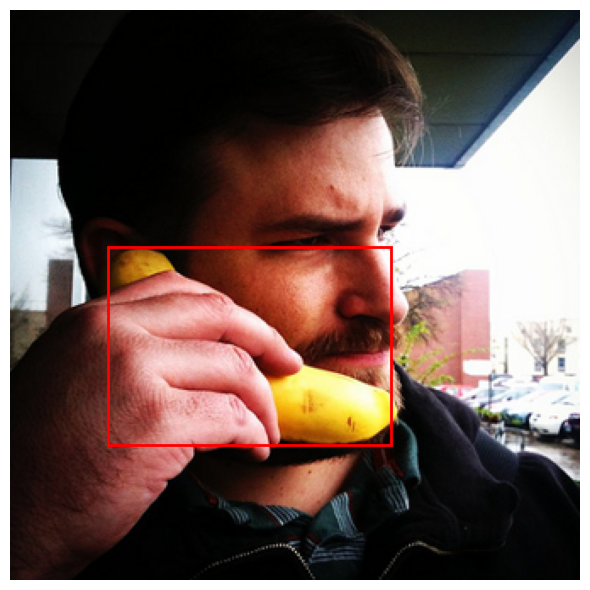

In [258]:
plot_boxes_on_image(image_tensor, total_data["downscale_target_words_bb_info"].iloc[i][j]["bbox"], image_processor=image_processor, labels=None,
                        linewidth=2, color="red")

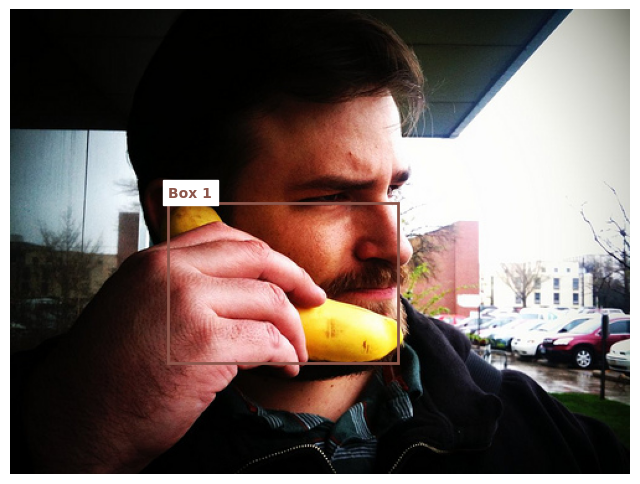

In [259]:
plot_bounding_boxes_xyxy(image_path, total_data["target_words"].iloc[i][j]["bbox"])

In [261]:
total_data.head(2)

,image_id,question,answer,target_words,downscale_target_words_bb_info
0,2414839,Where is the woman located in relation to the ...,"Situated to the left of the building, which is...","[{'word': 'building', 'class': None, 'bbox': [...","[{'word': 'building', 'class': None, 'bbox': [..."
1,2350091,What color is the cow located to the right of ...,The cow of the same color as the spots to the ...,"[{'word': 'brown cow', 'class': None, 'bbox': ...","[{'word': 'brown cow', 'class': None, 'bbox': ..."


In [265]:
total_data["image_path"] = total_data["image_id"].apply(lambda x: "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + str(int(x)) + ".jpg")

In [266]:
total_data.head(2)

,image_id,question,answer,target_words,downscale_target_words_bb_info,image_path
0,2414839,Where is the woman located in relation to the ...,"Situated to the left of the building, which is...","[{'word': 'building', 'class': None, 'bbox': [...","[{'word': 'building', 'class': None, 'bbox': [...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...
1,2350091,What color is the cow located to the right of ...,The cow of the same color as the spots to the ...,"[{'word': 'brown cow', 'class': None, 'bbox': ...","[{'word': 'brown cow', 'class': None, 'bbox': ...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...


In [268]:
total_data.to_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/finecops_ref/downscaled_total_finecops_ref_evidence_head_train_data_30k.csv", index=False)